###Primeiro passo precisamos baixar o Dataset que usaremos para resolver esse problema específico, no caso desse código, usaremos o 'cats and dogs' do Kaggle

In [38]:
import os
import requests
import zipfile

def download_dataset(url, save_dir):
    """
    Função para baixar um dataset a partir de uma URL.

    Args:
        url (str): URL do dataset para download.
        save_dir (str): Diretório onde o dataset será salvo.

    Returns:
        str: Caminho completo do arquivo baixado.
    """
    # Cria o diretório se ele não existir
    os.makedirs(save_dir, exist_ok=True)

    # Obtém o nome do arquivo a partir da URL
    file_name = os.path.basename(url)
    save_path = os.path.join(save_dir, file_name)

    # Faz o download do dataset
    print(f"Baixando dataset de {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Download concluído. Arquivo salvo em: {save_path}")
    else:
        raise Exception(f"Falha ao baixar o dataset. Código de status: {response.status_code}")

    with zipfile.ZipFile(save_path, 'r') as zip_ref:
      zip_ref.extractall(save_dir)
      print(f"Arquivo extraído em: {save_dir}")

In [39]:
url ="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
save_dir = "dataset"
download_dataset(url, save_dir)


Baixando dataset de https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip...
Download concluído. Arquivo salvo em: dataset/cats_and_dogs_filtered.zip
Arquivo extraído em: dataset


###Função para deixar os arquivos separados apenas em cats e dogs, sem separar por treino e validação

In [40]:
import os
import shutil

# Caminho da pasta principal
base_dir = "dataset/cats_and_dogs_filtered"

# Pastas originais
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# Pastas de destino
cats_dir = os.path.join(base_dir, "cats")
dogs_dir = os.path.join(base_dir, "dogs")

# Cria as pastas de destino se não existirem
os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

# Função para mover arquivos de uma subpasta para a pasta destino
def mover_imagens(origem, destino):
    for arquivo in os.listdir(origem):
        origem_arquivo = os.path.join(origem, arquivo)
        destino_arquivo = os.path.join(destino, arquivo)
        if os.path.isfile(origem_arquivo):  # Evita mover diretórios por engano
            shutil.move(origem_arquivo, destino_arquivo)

# Move todas as imagens de gatos
mover_imagens(os.path.join(train_dir, "cats"), cats_dir)
mover_imagens(os.path.join(val_dir, "cats"), cats_dir)

# Move todas as imagens de cachorros
mover_imagens(os.path.join(train_dir, "dogs"), dogs_dir)
mover_imagens(os.path.join(val_dir, "dogs"), dogs_dir)

print("Organização concluída!")

def delete_folder(folder_path):
    """
    Exclui uma pasta e todo o seu conteúdo de forma recursiva e forçada.

    Args:
        folder_path (str): Caminho da pasta a ser excluída.
    """
    if os.path.exists(folder_path):
        print(f"Excluindo a pasta e seu conteúdo: {folder_path}")
        shutil.rmtree(folder_path)
        print(f"Pasta excluída com sucesso: {folder_path}")
    else:
        print(f"A pasta não existe: {folder_path}")
delete_folder(train_dir)
delete_folder(val_dir)


Organização concluída!
Excluindo a pasta e seu conteúdo: dataset/cats_and_dogs_filtered/train
Pasta excluída com sucesso: dataset/cats_and_dogs_filtered/train
Excluindo a pasta e seu conteúdo: dataset/cats_and_dogs_filtered/validation
Pasta excluída com sucesso: dataset/cats_and_dogs_filtered/validation


Função abaixo exclui a pasta Dataset, utilizada para verificar se os download estão sendo baixados de forma correta

In [37]:
'''import shutil
import os

def delete_folder(folder_path):
    """
    Exclui uma pasta e todo o seu conteúdo de forma recursiva e forçada.

    Args:
        folder_path (str): Caminho da pasta a ser excluída.
    """
    if os.path.exists(folder_path):
        print(f"Excluindo a pasta e seu conteúdo: {folder_path}")
        shutil.rmtree(folder_path)
        print(f"Pasta excluída com sucesso: {folder_path}")
    else:
        print(f"A pasta não existe: {folder_path}")
delete_folder(save_dir)'''


Excluindo a pasta e seu conteúdo: dataset
Pasta excluída com sucesso: dataset


###Segundo passo agora é carregar as imagens e aplicar o pré-processamento:
-> Aplicar image size com o valor igual de quando for instanciar o modelo para não ter problemas com tamanho de imagens diferentes

-> Splitar validação e treinamento

In [42]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, optimizers, utils
dictory = "dataset/cats_and_dogs_filtered"
train_dataset , val_dataset = keras.preprocessing.image_dataset_from_directory(
  dictory,
  validation_split=0.2,
  subset="both",
  seed = 1,
  image_size=(160, 160))


Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Using 600 files for validation.


In [43]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


###Instanciando o modelo pré-treinado para carregar os pesos dele:

- weights='imagenet' --> significa que o modelo "MobileNetV2" irá usar os pesos pré-treinado na base de dados "ImageNet"


-  include_top=False --> significa que vai ser descartado a última camada de neurônios(porque você vai substituir essas camadas pelo seu próprio "topo" adaptado ao problema.)

-  input_shape=(160, 160, 3) --> ajustando ao mesmo shape do Tensor de treino e validação


In [44]:
from tensorflow.keras.applications import MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                                     include_top=False,
                                                     weights='imagenet')

####Definindo "pretrained_model.trainable = False" para coongelar as camadas do modelo, ou seja, para que durante o processo de Transfer Learning os pesos não se alterem

In [45]:
pretrained_model.trainable = False

####Criação das camadas finais do modelo, um novo "modelo no topo" para adaptar o modelo genérico ao problema específico

In [46]:
model = models.Sequential([
  pretrained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(2, activation='softmax') # Para duas classes
])

In [47]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
       loss='sparse_categorical_crossentropy',
       metrics=['accuracy'])

####Treinamento do modelo

In [49]:
history = model.fit(train_dataset,
          epochs=30, #colocar o valor 10 fica mais rapido para inicialmente treinar os dados
          validation_data=val_dataset)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 908ms/step - accuracy: 0.7765 - loss: 0.4749 - val_accuracy: 0.7567 - val_loss: 0.5154
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 794ms/step - accuracy: 0.7898 - loss: 0.4598 - val_accuracy: 0.7600 - val_loss: 0.5034
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 92s 930ms/step - accuracy: 0.7902 - loss: 0.4555 - val_accuracy: 0.7700 - val_loss: 0.5010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 813ms/step - accuracy: 0.8058 - loss: 0.4397 - val_accuracy: 0.7683 - val_loss: 0.5041
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 900ms/step - accuracy: 0.8019 - loss: 0.4485 - val_accuracy: 0.7750 - val_loss: 0.4962
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 817ms/step - accuracy: 0.7996 - loss: 0.4401 - val_accuracy: 0.7733 - val_loss: 0.4933
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 805ms/step - accuracy: 0.8017 - loss: 0.4330 - val_accuracy: 0.7767 - val_loss: 0.4901
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 816ms/step - accuracy: 0.8058 - loss: 0.4386 - val_accu

In [50]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Accuracy: {accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 636ms/step - accuracy: 0.7757 - loss: 0.4357
Accuracy: 77.33%


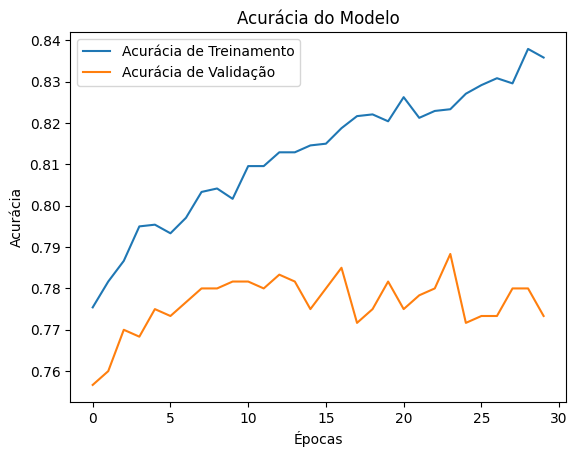

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()